In [19]:
import pandas as pd

In [20]:
df = pd.read_csv('data/unified_exoplanets_final_imputed.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15886 entries, 0 to 15885
Data columns (total 44 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   planet_name                                15886 non-null  object 
 1   host_star_id                               15886 non-null  int64  
 2   mission                                    15886 non-null  object 
 3   disposition                                15886 non-null  object 
 4   orbital_period_days                        15886 non-null  float64
 5   transit_epoch_bjd                          15886 non-null  float64
 6   transit_duration_hours                     15886 non-null  float64
 7   transit_depth_ppm                          15886 non-null  float64
 8   planet_radius_re                           15886 non-null  float64
 9   planet_mass_me                             0 non-null      float64
 10  equilibrium_temp_k    

In [21]:
# drop columns with any nulls and show the result
df = df.dropna(axis=1, how='any')
print("Shape after dropping columns with any nulls:", df.shape)
print("Remaining columns:", df.columns.tolist())

Shape after dropping columns with any nulls: (15886, 31)
Remaining columns: ['planet_name', 'host_star_id', 'mission', 'disposition', 'orbital_period_days', 'transit_epoch_bjd', 'transit_duration_hours', 'transit_depth_ppm', 'planet_radius_re', 'equilibrium_temp_k', 'insolation_flux', 'impact_parameter', 'stellar_teff_k', 'stellar_radius_rsun', 'stellar_radius_normal', 'stellar_mass_msun', 'mass_rad_ratio', 'stellar_logg', 'acc_grav_stellar_surface', 'ra', 'dec', 'transit_depth_ppm_imputed', 'transit_duration_hours_imputed', 'radius_ratio_est', 'stellar_teff_k_imputed', 'stellar_radius_rsun_imputed', 'planet_radius_re_imputed', 'impact_parameter_imputed', 'stellar_metallicity_high_missingness_flag', 'equilibrium_temp_k_imputed', 'stellar_logg_imputed']


In [22]:
# Check data types and identify non-numeric columns
print("Data types:")
print(df.dtypes.value_counts())
print("\nNon-numeric columns:")
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()
print(non_numeric_cols)
print(f"\nTotal non-numeric columns: {len(non_numeric_cols)}")

print("\nNumeric columns:")
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"Total numeric columns: {len(numeric_cols)}")
print(numeric_cols[:10], "..." if len(numeric_cols) > 10 else "")

Data types:
float64    18
bool        9
object      3
int64       1
Name: count, dtype: int64

Non-numeric columns:
['planet_name', 'mission', 'disposition', 'transit_depth_ppm_imputed', 'transit_duration_hours_imputed', 'stellar_teff_k_imputed', 'stellar_radius_rsun_imputed', 'planet_radius_re_imputed', 'impact_parameter_imputed', 'stellar_metallicity_high_missingness_flag', 'equilibrium_temp_k_imputed', 'stellar_logg_imputed']

Total non-numeric columns: 12

Numeric columns:
Total numeric columns: 19
['host_star_id', 'orbital_period_days', 'transit_epoch_bjd', 'transit_duration_hours', 'transit_depth_ppm', 'planet_radius_re', 'equilibrium_temp_k', 'insolation_flux', 'impact_parameter', 'stellar_teff_k'] ...


In [23]:
# Create binary labels and filter for supervised learning

def create_binary_labels(labels: pd.Series) -> pd.Series:
    """Convert disposition labels to binary classification"""
    binary_map = {
        'CONFIRMED': 1,          # Positive class - confirmed exoplanets
        'FALSE POSITIVE': 0,     # Negative class
        'REFUTED': 0,            # Treat as false positive  
        'FA': 0,                 # False alarm as negative
        # Exclude uncertain labels from supervised training
        'CANDIDATE': None,
        'KP': None, 
        'CP': None,
    }
    return labels.map(binary_map)

# Apply binary mapping and filter definitive labels
binary_labels = create_binary_labels(df['disposition'])
mask = ~binary_labels.isna()
df_supervised = df.loc[mask].copy()
df_supervised['label'] = binary_labels.loc[mask].astype(int)

print(f"Supervised dataset shape: {df_supervised.shape}")
print(f"Class distribution:\n{df_supervised['label'].value_counts()}")
print(f"Positive class ratio: {df_supervised['label'].mean():.3f}")

Supervised dataset shape: (8367, 32)
Class distribution:
label
0    5623
1    2744
Name: count, dtype: int64
Positive class ratio: 0.328


In [24]:
# Feature preparation and selection
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

# Get only numeric columns and exclude non-feature columns
numeric_cols = df_supervised.select_dtypes(include=['number']).columns.tolist()

# Exclude target, identifier, and flag columns
exclude_patterns = ['disposition', 'label', 'planet_name', 'mission', '_imputed', 'host_star_id']
feature_cols = []

for col in numeric_cols:
    should_exclude = False
    for pattern in exclude_patterns:
        if pattern in col:
            should_exclude = True
            break
    if not should_exclude:
        feature_cols.append(col)

print(f"Total columns: {len(df_supervised.columns)}")
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Available features after filtering: {len(feature_cols)}")
print(f"Excluded columns: {len(df_supervised.columns) - len(feature_cols)}")

print("\nSelected feature columns:")
for i, col in enumerate(feature_cols):
    print(f"  {i+1}. {col}")

# Prepare feature matrix and target
X = df_supervised[feature_cols].copy()
y = df_supervised['label'].copy()

# Handle any remaining missing values
X = X.fillna(X.median())

# Verify no non-numeric data
print(f"\nFeature matrix data types:")
print(X.dtypes.value_counts())

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution: {np.bincount(y)}")

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Training class distribution: {np.bincount(y_train)}")
print(f"Test class distribution: {np.bincount(y_test)}")

Total columns: 32
Numeric columns: 20
Available features after filtering: 18
Excluded columns: 14

Selected feature columns:
  1. orbital_period_days
  2. transit_epoch_bjd
  3. transit_duration_hours
  4. transit_depth_ppm
  5. planet_radius_re
  6. equilibrium_temp_k
  7. insolation_flux
  8. impact_parameter
  9. stellar_teff_k
  10. stellar_radius_rsun
  11. stellar_radius_normal
  12. stellar_mass_msun
  13. mass_rad_ratio
  14. stellar_logg
  15. acc_grav_stellar_surface
  16. ra
  17. dec
  18. radius_ratio_est

Feature matrix data types:
float64    18
Name: count, dtype: int64

Feature matrix shape: (8367, 18)
Target distribution: [5623 2744]

Training set: (6693, 18)
Test set: (1674, 18)
Training class distribution: [4498 2195]
Test class distribution: [1125  549]


Feature Selection Configuration:
  Top K Features: 12
  Total Available Features: 18

F-Score Rankings (Top 15):
 6. equilibrium_temp_k        | F-Score:   656.69 | p-value: 3.05e-138
 8. impact_parameter          | F-Score:   571.68 | p-value: 2.64e-121
18. radius_ratio_est          | F-Score:   547.11 | p-value: 2.26e-116
 2. transit_epoch_bjd         | F-Score:   487.05 | p-value: 3.04e-104
 4. transit_depth_ppm         | F-Score:   317.02 | p-value: 2.52e-69
 9. stellar_teff_k            | F-Score:   284.28 | p-value: 1.69e-62
14. stellar_logg              | F-Score:   236.43 | p-value: 1.85e-52
12. stellar_mass_msun         | F-Score:   220.45 | p-value: 4.33e-49
17. dec                       | F-Score:   207.96 | p-value: 1.90e-46
16. ra                        | F-Score:   193.91 | p-value: 1.79e-43
 3. transit_duration_hours    | F-Score:   113.17 | p-value: 3.21e-26
15. acc_grav_stellar_surface  | F-Score:   110.71 | p-value: 1.09e-25
13. mass_rad_ratio            | F-Score:   

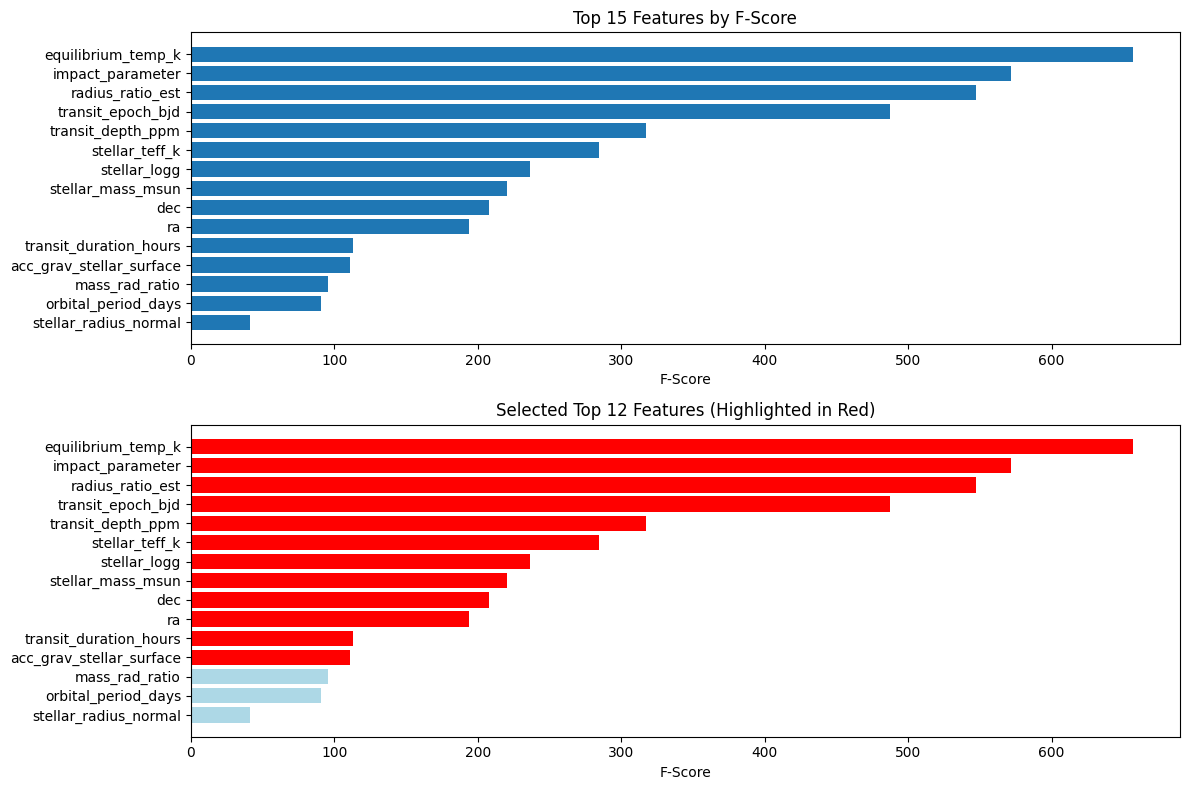


Final feature matrix shape: (6693, 12)
Feature reduction: 18 → 12 features (66.7%)


In [25]:
# Enhanced feature selection with F-score calculation
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Configuration parameters
TOP_K_FEATURES = 12  # Configurable parameter - can be easily changed
RANDOM_STATE = 42

print(f"Feature Selection Configuration:")
print(f"  Top K Features: {TOP_K_FEATURES}")
print(f"  Total Available Features: {len(feature_cols)}")

# Scale features first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Calculate F-scores for all features
f_scores, p_values = f_classif(X_train_scaled, y_train)

# Create feature scoring dataframe
feature_scores_df = pd.DataFrame({
    'feature': feature_cols,
    'f_score': f_scores,
    'p_value': p_values
}).sort_values('f_score', ascending=False)

print(f"\nF-Score Rankings (Top 15):")
print("=" * 50)
for i, row in feature_scores_df.head(15).iterrows():
    print(f"{row.name+1:2d}. {row['feature']:<25} | F-Score: {row['f_score']:8.2f} | p-value: {row['p_value']:.2e}")

# Feature selection using top K features
k_features = min(TOP_K_FEATURES, len(feature_cols))
selector = SelectKBest(score_func=f_classif, k=k_features)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names and scores
selected_indices = selector.get_support(indices=True)
selected_features = [feature_cols[i] for i in selected_indices]
selected_f_scores = [f_scores[i] for i in selected_indices]

print(f"\nSelected Top {k_features} Features:")
print("=" * 50)
for i, (feature, score) in enumerate(zip(selected_features, selected_f_scores)):
    print(f"{i+1:2d}. {feature:<25} | F-Score: {score:8.2f}")

# Visualization of F-scores
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
top_15_features = feature_scores_df.head(15)
plt.barh(range(len(top_15_features)), top_15_features['f_score'])
plt.yticks(range(len(top_15_features)), top_15_features['feature'])
plt.xlabel('F-Score')
plt.title('Top 15 Features by F-Score')
plt.gca().invert_yaxis()

# Highlight selected features
plt.subplot(2, 1, 2)
colors = ['red' if f in selected_features else 'lightblue' for f in top_15_features['feature']]
plt.barh(range(len(top_15_features)), top_15_features['f_score'], color=colors)
plt.yticks(range(len(top_15_features)), top_15_features['feature'])
plt.xlabel('F-Score')
plt.title(f'Selected Top {k_features} Features (Highlighted in Red)')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print(f"\nFinal feature matrix shape: {X_train_selected.shape}")
print(f"Feature reduction: {len(feature_cols)} → {k_features} features ({k_features/len(feature_cols)*100:.1f}%)")

In [26]:
# Random Over-Sampling (ROS) for class imbalance
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Apply Random Over-Sampling
ros = RandomOverSampler(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_selected, y_train)

print("Class distribution before resampling:")
print(Counter(y_train))
print("\nClass distribution after resampling:")
print(Counter(y_train_resampled))
print(f"Resampled training set shape: {X_train_resampled.shape}")

# Store resampling info for metadata
resampling_info = {
    'method': 'RandomOverSampler',
    'original_distribution': dict(Counter(y_train)),
    'resampled_distribution': dict(Counter(y_train_resampled)),
    'original_size': len(y_train),
    'resampled_size': len(y_train_resampled)
}

Class distribution before resampling:
Counter({0: 4498, 1: 2195})

Class distribution after resampling:
Counter({0: 4498, 1: 4498})
Resampled training set shape: (8996, 12)


In [27]:
# Parameter Grid Configuration for Cross-Validation
from sklearn.model_selection import GridSearchCV
import json

# Simple, tweakable parameter grids
param_grids = {
    'rf': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    },
    'gb': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 10]
    },
    'svm': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['rbf', 'linear']
    },
    'lr': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'lbfgs']
    }
}

# Configuration parameters
CV_FOLDS = 3  # Reduced for faster computation, can be increased
SCORING_METRIC = 'roc_auc'
N_JOBS = -1  # Use all available cores

print("Parameter Grid Configuration:")
print("=" * 40)
for model_name, grid in param_grids.items():
    param_combinations = 1
    for param, values in grid.items():
        param_combinations *= len(values)
    print(f"{model_name.upper()}:")
    print(f"  Parameters: {list(grid.keys())}")
    print(f"  Combinations: {param_combinations}")
    print()

print(f"Cross-Validation Configuration:")
print(f"  CV Folds: {CV_FOLDS}")
print(f"  Scoring Metric: {SCORING_METRIC}")
print(f"  Parallel Jobs: {N_JOBS}")

# Store configuration for metadata
cv_config = {
    'cv_folds': CV_FOLDS,
    'scoring_metric': SCORING_METRIC,
    'param_grids': param_grids,
    'top_k_features': TOP_K_FEATURES,
    'random_state': RANDOM_STATE
}

Parameter Grid Configuration:
RF:
  Parameters: ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf']
  Combinations: 36

GB:
  Parameters: ['n_estimators', 'learning_rate', 'max_depth']
  Combinations: 27

SVM:
  Parameters: ['C', 'gamma', 'kernel']
  Combinations: 12

LR:
  Parameters: ['C', 'penalty', 'solver']
  Combinations: 12

Cross-Validation Configuration:
  CV Folds: 3
  Scoring Metric: roc_auc
  Parallel Jobs: -1


In [28]:
# Enhanced Model Training with Cross-Validation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score, cross_validate
import time

# Define base models with default parameters
base_models_default = {
    'rf': RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=N_JOBS),
    'gb': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'svm': SVC(probability=True, random_state=RANDOM_STATE),
    'lr': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
}

# Perform GridSearchCV for each base model
print("Performing Grid Search Cross-Validation...")
print("=" * 50)

best_models = {}
cv_results = {}

for model_name, base_model in base_models_default.items():
    print(f"\nOptimizing {model_name.upper()}...")
    start_time = time.time()
    
    # Special handling for LogisticRegression solver compatibility
    if model_name == 'lr':
        # Filter solver-penalty combinations
        valid_params = []
        for C in param_grids[model_name]['C']:
            for penalty in param_grids[model_name]['penalty']:
                for solver in param_grids[model_name]['solver']:
                    if (penalty == 'l1' and solver == 'lbfgs') or \
                       (penalty == 'l2' and solver == 'liblinear'):
                        continue  # Skip invalid combinations
                    valid_params.append({'C': C, 'penalty': penalty, 'solver': solver})
        
        # Custom grid search for LogisticRegression
        best_score = -1
        best_params = None
        for params in valid_params:
            model = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, **params)
            scores = cross_val_score(model, X_train_resampled, y_train_resampled, 
                                   cv=CV_FOLDS, scoring=SCORING_METRIC, n_jobs=N_JOBS)
            mean_score = scores.mean()
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
        
        best_models[model_name] = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, **best_params)
        cv_results[model_name] = {'best_score': best_score, 'best_params': best_params}
        
    else:
        # Standard GridSearchCV for other models
        grid_search = GridSearchCV(
            base_model, 
            param_grids[model_name], 
            cv=CV_FOLDS, 
            scoring=SCORING_METRIC,
            n_jobs=N_JOBS,
            verbose=0
        )
        
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_models[model_name] = grid_search.best_estimator_
        cv_results[model_name] = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_
        }
    
    elapsed_time = time.time() - start_time
    print(f"  Best CV Score: {cv_results[model_name]['best_score']:.4f}")
    print(f"  Best Params: {cv_results[model_name]['best_params']}")
    print(f"  Time: {elapsed_time:.1f}s")

print(f"\nGrid Search completed for all models!")

# Create optimized base models list for stacking
optimized_estimators = [(name, model) for name, model in best_models.items()]

# Meta-learner (final classifier)
meta_learner = LogisticRegression(random_state=RANDOM_STATE)

# Create stacking classifier with optimized base models
stacking_clf = StackingClassifier(
    estimators=optimized_estimators,
    final_estimator=meta_learner,
    cv=CV_FOLDS,
    stack_method='predict_proba',
    n_jobs=N_JOBS
)

print(f"\nOptimized Stacking Ensemble Created:")
print(f"  Base Models: {list(best_models.keys())}")
print(f"  Meta-learner: {meta_learner.__class__.__name__}")
print(f"  Stacking CV Folds: {CV_FOLDS}")

Performing Grid Search Cross-Validation...

Optimizing RF...
  Best CV Score: 0.9872
  Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Time: 21.0s

Optimizing GB...
  Best CV Score: 0.9872
  Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
  Time: 21.0s

Optimizing GB...
  Best CV Score: 0.9912
  Best Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
  Time: 71.9s

Optimizing SVM...
  Best CV Score: 0.9912
  Best Params: {'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200}
  Time: 71.9s

Optimizing SVM...
  Best CV Score: 0.9654
  Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  Time: 21.9s

Optimizing LR...
  Best CV Score: 0.9654
  Best Params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
  Time: 21.9s

Optimizing LR...
  Best CV Score: 0.8966
  Best Params: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
  Time: 0.7s

Grid Search complete

In [29]:
# Base models for stacking ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score

# Define base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
]

# Meta-learner (final classifier)
meta_learner = LogisticRegression(random_state=42)

# Create stacking classifier
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

print("Base models defined:")
for name, model in base_models:
    print(f"  - {name}: {model.__class__.__name__}")
print(f"Meta-learner: {meta_learner.__class__.__name__}")

Base models defined:
  - rf: RandomForestClassifier
  - gb: GradientBoostingClassifier
  - svm: SVC
  - lr: LogisticRegression
Meta-learner: LogisticRegression


In [30]:
# Comprehensive Model Evaluation
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score,
                           accuracy_score, f1_score, precision_score, recall_score)
import matplotlib.pyplot as plt

print("Training Final Stacking Ensemble...")
start_time = time.time()
stacking_clf.fit(X_train_resampled, y_train_resampled)
training_time = time.time() - start_time
print(f"Training completed in {training_time:.1f} seconds")

# Make predictions on both training and test sets
print("\nGenerating predictions...")

# Training set predictions (for overfitting analysis)
y_train_pred = stacking_clf.predict(X_train_selected)
y_train_pred_proba = stacking_clf.predict_proba(X_train_selected)[:, 1]

# Test set predictions
y_test_pred = stacking_clf.predict(X_test_selected)
y_test_pred_proba = stacking_clf.predict_proba(X_test_selected)[:, 1]

# Calculate comprehensive metrics
def calculate_metrics(y_true, y_pred, y_pred_proba, set_name):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'avg_precision': average_precision_score(y_true, y_pred_proba)
    }
    
    print(f"\n{set_name} Set Performance:")
    print("=" * 30)
    for metric, value in metrics.items():
        print(f"{metric.upper():<15}: {value:.4f}")
    
    return metrics

# Calculate metrics for both sets
train_metrics = calculate_metrics(y_train, y_train_pred, y_train_pred_proba, "TRAINING")
test_metrics = calculate_metrics(y_test, y_test_pred, y_test_pred_proba, "TEST")

# Check for overfitting
print(f"\nOverfitting Analysis:")
print("=" * 25)
print(f"Train-Test Accuracy Gap: {train_metrics['accuracy'] - test_metrics['accuracy']:.4f}")
print(f"Train-Test F1 Gap:      {train_metrics['f1_score'] - test_metrics['f1_score']:.4f}")
print(f"Train-Test AUC Gap:     {train_metrics['roc_auc'] - test_metrics['roc_auc']:.4f}")

# Detailed classification reports
print(f"\nDetailed Classification Report (Test Set):")
print("=" * 50)
print(classification_report(y_test, y_test_pred, target_names=['Not Confirmed', 'Confirmed']))

print(f"\nConfusion Matrix (Test Set):")
print("=" * 30)
cm = confusion_matrix(y_test, y_test_pred)
print(f"                    Predicted")
print(f"                Not Conf  Confirmed")
print(f"Actual Not Conf     {cm[0,0]:4d}      {cm[0,1]:4d}")
print(f"       Confirmed    {cm[1,0]:4d}      {cm[1,1]:4d}")

# Store all metrics for metadata
final_metrics = {
    'training_metrics': train_metrics,
    'test_metrics': test_metrics,
    'training_time_seconds': training_time,
    'confusion_matrix': cm.tolist(),
    'overfitting_analysis': {
        'accuracy_gap': train_metrics['accuracy'] - test_metrics['accuracy'],
        'f1_gap': train_metrics['f1_score'] - test_metrics['f1_score'],
        'auc_gap': train_metrics['roc_auc'] - test_metrics['roc_auc']
    }
}

Training Final Stacking Ensemble...
Training completed in 9.5 seconds

Generating predictions...
Training completed in 9.5 seconds

Generating predictions...

TRAINING Set Performance:
ACCURACY       : 1.0000
F1_SCORE       : 1.0000
PRECISION      : 1.0000
RECALL         : 1.0000
ROC_AUC        : 1.0000
AVG_PRECISION  : 1.0000

TEST Set Performance:
ACCURACY       : 0.8955
F1_SCORE       : 0.8366
PRECISION      : 0.8582
RECALL         : 0.8160
ROC_AUC        : 0.9637
AVG_PRECISION  : 0.9280

Overfitting Analysis:
Train-Test Accuracy Gap: 0.1045
Train-Test F1 Gap:      0.1634
Train-Test AUC Gap:     0.0363

Detailed Classification Report (Test Set):
               precision    recall  f1-score   support

Not Confirmed       0.91      0.93      0.92      1125
    Confirmed       0.86      0.82      0.84       549

     accuracy                           0.90      1674
    macro avg       0.89      0.88      0.88      1674
 weighted avg       0.89      0.90      0.89      1674


Confusion

In [31]:
# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Make predictions
y_pred = stacking_clf.predict(X_test_selected)
y_pred_proba = stacking_clf.predict_proba(X_test_selected)[:, 1]

# Calculate metrics
auc_score = roc_auc_score(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

print("Model Performance Metrics:")
print(f"ROC AUC Score: {auc_score:.4f}")
print(f"Average Precision Score: {avg_precision:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Model Performance Metrics:
ROC AUC Score: 0.9637
Average Precision Score: 0.9280

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1125
           1       0.86      0.82      0.84       549

    accuracy                           0.90      1674
   macro avg       0.89      0.88      0.88      1674
weighted avg       0.89      0.90      0.89      1674


Confusion Matrix:
[[1051   74]
 [ 101  448]]


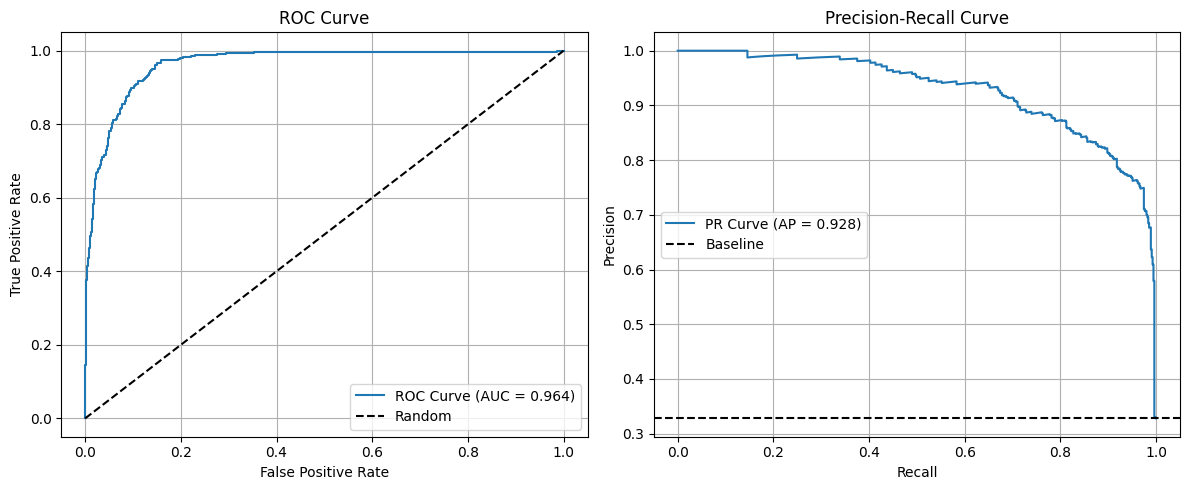

In [32]:
# Visualization of model performance
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[0].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve')
axes[0].legend()
axes[0].grid(True)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
axes[1].plot(recall, precision, label=f'PR Curve (AP = {avg_precision:.3f})')
axes[1].axhline(y=y_test.mean(), color='k', linestyle='--', label='Baseline')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [33]:
# Cross-validation performance
print("Cross-validation performance:")
cv_scores = cross_val_score(stacking_clf, X_train_selected, y_train, cv=5, scoring='roc_auc')
print(f"CV ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

cv_scores_pr = cross_val_score(stacking_clf, X_train_selected, y_train, cv=5, scoring='average_precision')
print(f"CV Average Precision: {cv_scores_pr.mean():.4f} (+/- {cv_scores_pr.std() * 2:.4f})")

Cross-validation performance:
CV ROC AUC: 0.9655 (+/- 0.0079)
CV ROC AUC: 0.9655 (+/- 0.0079)
CV Average Precision: 0.9259 (+/- 0.0195)
CV Average Precision: 0.9259 (+/- 0.0195)


Top 10 Most Important Features:
                 feature  importance
      equilibrium_temp_k    0.169109
        impact_parameter    0.135141
       transit_depth_ppm    0.118571
        radius_ratio_est    0.110711
       transit_epoch_bjd    0.106533
  transit_duration_hours    0.074576
          stellar_teff_k    0.057041
                      ra    0.054038
acc_grav_stellar_surface    0.049364
            stellar_logg    0.043828


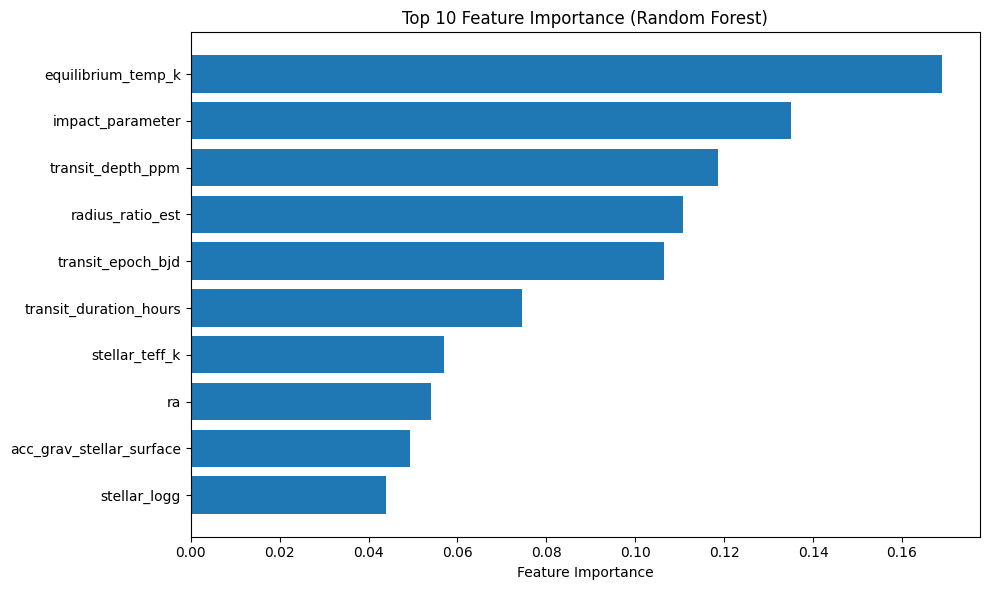

In [34]:
# Feature importance analysis
try:
    # Get feature importance from Random Forest (most interpretable base model)
    rf_model = stacking_clf.named_estimators_['rf']
    feature_importance = rf_model.feature_importances_
    
    # Create feature importance dataframe
    importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(importance_df.head(10).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = importance_df.head(10)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importance (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Feature importance analysis failed: {e}")

In [35]:
# Comprehensive Model Persistence and Metadata Generation
import pickle
import json
import os
from datetime import datetime

# Create models directory
os.makedirs('models', exist_ok=True)

print("Generating comprehensive metadata...")

# Create comprehensive metadata
metadata = {
    "model_info": {
        "model_type": "StackingClassifier",
        "base_models": list(best_models.keys()),
        "meta_learner": "LogisticRegression",
        "training_date": datetime.now().isoformat(),
        "training_time_seconds": training_time,
        "random_state": RANDOM_STATE
    },
    "dataset_info": {
        "total_samples": len(df_supervised),
        "training_samples": len(y_train),
        "test_samples": len(y_test),
        "resampled_training_samples": len(y_train_resampled),
        "original_features": len(feature_cols),
        "selected_features": len(selected_features),
        "feature_selection_method": "F-score (SelectKBest)",
        "top_k_features": TOP_K_FEATURES
    },
    "selected_features": {
        "feature_names": selected_features,
        "f_scores": {feature: float(score) for feature, score in zip(selected_features, selected_f_scores)},
        "feature_ranking": feature_scores_df.head(len(selected_features)).to_dict('records')
    },
    "preprocessing": {
        "scaling_method": "StandardScaler",
        "resampling_method": "RandomOverSampler",
        "resampling_info": resampling_info
    },
    "hyperparameter_optimization": {
        "cv_folds": CV_FOLDS,
        "scoring_metric": SCORING_METRIC,
        "optimization_results": cv_results,
        "param_grids": param_grids
    },
    "performance_metrics": final_metrics,
    "deployment_info": {
        "required_libraries": ["pandas", "numpy", "scikit-learn", "matplotlib", "shap", "imbalanced-learn"],
        "python_version": ">=3.8",
        "model_files": [
            "stacking_classifier.pkl",
            "scaler.pkl", 
            "feature_selector.pkl",
            "ros_sampler.pkl",
            "metadata.json"
        ],
        "input_features": selected_features,
        "output_classes": ["Not Confirmed (0)", "Confirmed (1)"],
        "prediction_threshold": 0.5
    },
    "model_artifacts": {
        "stacking_classifier": "Complete trained stacking ensemble",
        "scaler": "StandardScaler fitted on training data",
        "feature_selector": "SelectKBest selector for top features",
        "ros_sampler": "RandomOverSampler for class balancing",
        "selected_features": "List of selected feature names"
    }
}

# Save metadata as JSON
metadata_path = 'models/metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✓ Saved comprehensive metadata to {metadata_path}")

# Save all model components
model_artifacts = {
    'stacking_classifier': stacking_clf,
    'scaler': scaler,
    'feature_selector': selector,
    'ros_sampler': ros,
    'selected_features': selected_features,
    'feature_scores': feature_scores_df,
    'cv_results': cv_results,
    'best_models': best_models
}

print("\nSaving model artifacts:")
print("=" * 30)
for name, artifact in model_artifacts.items():
    filepath = f'models/{name}.pkl'
    with open(filepath, 'wb') as f:
        pickle.dump(artifact, f)
    print(f"✓ Saved {name} to {filepath}")

# Create deployment README
readme_content = f"""# Exoplanet Classification Model - Deployment Guide

## Model Overview
- **Model Type**: Stacking Ensemble (RF + GB + SVM + LR)
- **Task**: Binary Classification (Confirmed vs Not Confirmed Exoplanets)
- **Performance**: {test_metrics['roc_auc']:.4f} ROC AUC, {test_metrics['f1_score']:.4f} F1-Score
- **Training Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Quick Start
```python
import pickle
import pandas as pd

# Load model components
with open('models/stacking_classifier.pkl', 'rb') as f:
    model = pickle.load(f)
with open('models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)
with open('models/feature_selector.pkl', 'rb') as f:
    selector = pickle.load(f)
with open('models/selected_features.pkl', 'rb') as f:
    features = pickle.load(f)

# Make predictions
def predict_exoplanet(data):
    X_scaled = scaler.transform(data[features])
    X_selected = selector.transform(X_scaled)
    return model.predict_proba(X_selected)[:, 1]
```

## Required Features
{chr(10).join([f"- {feature}" for feature in selected_features])}

## Performance Summary
- **Test Accuracy**: {test_metrics['accuracy']:.4f}
- **Test F1-Score**: {test_metrics['f1_score']:.4f}
- **Test Precision**: {test_metrics['precision']:.4f}
- **Test Recall**: {test_metrics['recall']:.4f}
- **Test ROC AUC**: {test_metrics['roc_auc']:.4f}
- **Test Avg Precision**: {test_metrics['avg_precision']:.4f}

## Model Configuration
- **Selected Features**: {len(selected_features)} out of {len(feature_cols)}
- **Feature Selection**: F-score based (SelectKBest)
- **Class Balancing**: Random Over-Sampling
- **Cross-Validation**: {CV_FOLDS}-fold CV with {SCORING_METRIC}
"""

with open('models/README.md', 'w') as f:
    f.write(readme_content)
print(f"✓ Created deployment README: models/README.md")

# Summary
print(f"\nDeployment Package Summary:")
print("=" * 35)
print(f"📁 Models Directory: models/")
print(f"🔧 Artifacts: {len(model_artifacts)} pickle files")
print(f"📋 Metadata: metadata.json ({os.path.getsize(metadata_path)/1024:.1f} KB)")
print(f"📖 Documentation: README.md")
print(f"🎯 Test Performance: {test_metrics['roc_auc']:.4f} AUC, {test_metrics['f1_score']:.4f} F1")
print(f"⚡ Features: {len(selected_features)} selected from {len(feature_cols)} total")
print(f"✅ Ready for production deployment!")

Generating comprehensive metadata...
✓ Saved comprehensive metadata to models/metadata.json

Saving model artifacts:
✓ Saved stacking_classifier to models/stacking_classifier.pkl
✓ Saved scaler to models/scaler.pkl
✓ Saved feature_selector to models/feature_selector.pkl
✓ Saved ros_sampler to models/ros_sampler.pkl
✓ Saved selected_features to models/selected_features.pkl
✓ Saved feature_scores to models/feature_scores.pkl
✓ Saved cv_results to models/cv_results.pkl
✓ Saved best_models to models/best_models.pkl
✓ Created deployment README: models/README.md

Deployment Package Summary:
📁 Models Directory: models/
🔧 Artifacts: 8 pickle files
📋 Metadata: metadata.json (7.6 KB)
📖 Documentation: README.md
🎯 Test Performance: 0.9637 AUC, 0.8366 F1
⚡ Features: 12 selected from 18 total
✅ Ready for production deployment!


In [36]:
# Check data types and identify non-numeric columns
print("Data types:")
print(df.dtypes.value_counts())
print("\nNon-numeric columns:")
non_numeric_cols = df.select_dtypes(exclude=['number']).columns.tolist()
print(non_numeric_cols)
print(f"\nTotal non-numeric columns: {len(non_numeric_cols)}")

print("\nNumeric columns:")
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print(f"Total numeric columns: {len(numeric_cols)}")
print(numeric_cols[:10], "..." if len(numeric_cols) > 10 else "")

Data types:
float64    18
bool        9
object      3
int64       1
Name: count, dtype: int64

Non-numeric columns:
['planet_name', 'mission', 'disposition', 'transit_depth_ppm_imputed', 'transit_duration_hours_imputed', 'stellar_teff_k_imputed', 'stellar_radius_rsun_imputed', 'planet_radius_re_imputed', 'impact_parameter_imputed', 'stellar_metallicity_high_missingness_flag', 'equilibrium_temp_k_imputed', 'stellar_logg_imputed']

Total non-numeric columns: 12

Numeric columns:
Total numeric columns: 19
['host_star_id', 'orbital_period_days', 'transit_epoch_bjd', 'transit_duration_hours', 'transit_depth_ppm', 'planet_radius_re', 'equilibrium_temp_k', 'insolation_flux', 'impact_parameter', 'stellar_teff_k'] ...
